In [93]:
import random
import warnings
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline

warnings.filterwarnings("ignore")

### Shapley values

For feature $j$

$$\phi_j=\frac{1}{M} \sum_{m=1}^M\left(\hat{f}\left(x_{+j}^m\right)-\hat{f}\left(x_{-j}^m\right)\right)$$

where $\hat{f}\left(x_{+j}^m\right)$ is the prediction for $x$, but with a random number of feature values replaced by feature values from a random data point $z$, except for the respective value of feature $j$.

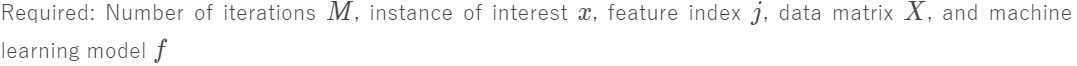
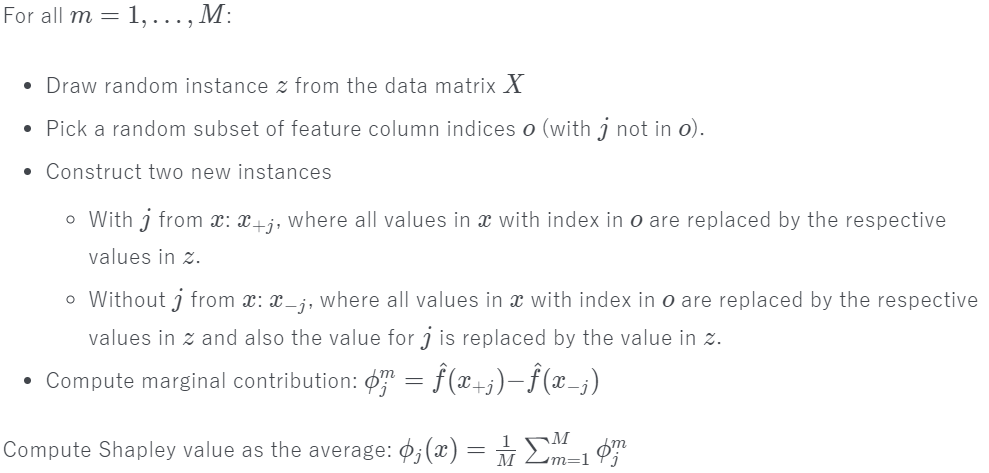

In [74]:
class shapley(object):
    def __init__(self, X, f):
        self.X = X
        self.f = f
        self.n_features = X.shape[-1]
        self.features = list(range(X.shape[-1]))
        
    def estimate(self, x, j_=None, M=1000):
        J  = self.features if j_ is None else [ j_ ]
        MC = [ ]
        for j in J:
            MC_j    = [ ]
            X_not_j = [ _ for _ in self.features if _ != j ]
            for m in range(M):
                # sample z
                z = self.X.sample(1).values[0]
                # sample n_K
                #n_K = np.random.choice(X_not_j)
                n_K = np.random.randint(self.n_features)
                # sample K(n_K)
                K = list(np.random.choice(X_not_j, n_K, replace=False))
                #K = list(np.random.choice(X_not_j, np.random.choice(X_not_j), replace=False))
                # create pseudo sample(s)
                xpj = np.array([ x[k] if k in K + [j] else z[k] for k in self.features ]).reshape(1, self.n_features)
                xmj = np.array([ x[k] if k in K       else z[k] for k in self.features ]).reshape(1, self.n_features)
                # calculate marginal contribution of j for iteration m
                MC_j += [ self.f(xpj) - self.f(xmj) ]
            # average to get the monte carlo estimate
            MC   += [ np.mean(MC_j) ]
        
        return np.array(MC)   

### Classification

In [75]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=2022
)

f = make_pipeline(StandardScaler(), LogisticRegression()).fit(X_train, y_train)

In [121]:
i = 137
x = X_test.iloc[i]

In [122]:
%%time
explainer   = shap.KernelExplainer(f.predict_proba, X_train)
shap_values = explainer.shap_values(x)[1]

Using 341 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


CPU times: total: 2.66 s
Wall time: 2.59 s


In [123]:
%%time
shapval = shapley(X_train, lambda x : f.predict_proba(x)[0, 1])
MC      = shapval.estimate(x)

CPU times: total: 18.9 s
Wall time: 18 s


Deviation of shapley values when compared with a library

In [127]:
((shap_values - MC)**2).mean().round(4)

0.0

The sum of contributions should yield the difference between actual and average prediction

In [128]:
f.predict_proba(x.values.reshape(1, -1))[:, 1] - f.predict_proba(X_train)[:, 1].mean()

array([0.36579791])

In [129]:
shap_values.sum(), MC.sum()

(0.36579790914618004, 0.36723772966228013)

<AxesSubplot: >

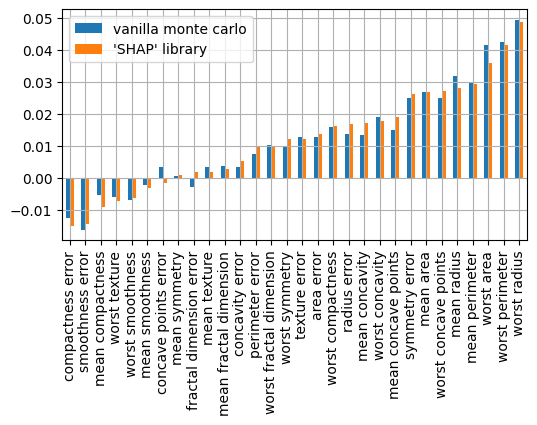

In [136]:
pd.DataFrame(np.transpose([MC, shap_values]),
             index=X.columns,
             columns=["vanilla monte carlo", "'SHAP' library"]).sort_values(by="'SHAP' library").plot.bar(grid=True, figsize=(6,3))

#### Regression

In [137]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)

f = make_pipeline(StandardScaler(), LinearRegression()).fit(X_train, y_train)

In [146]:
i = 137
x = X_test.iloc[i]

In [147]:
%%time
explainer   = shap.KernelExplainer(f.predict, X_train)
shap_values = explainer.shap_values(x)

Using 14448 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


CPU times: total: 17.2 s
Wall time: 17.2 s


In [148]:
%%time
shapval = shapley(X_train, lambda x : f.predict(x))
MC      = shapval.estimate(x)

CPU times: total: 6.61 s
Wall time: 5.67 s


Deviation of shapley values when compared with a library

In [149]:
((shap_values - MC)**2).mean().round(4)

0.0005

In [150]:
shap_values.sum(), MC.sum()

(0.3865003157910616, 0.3558212467336635)

The sum of contributions should yield the difference between actual and average prediction

In [151]:
f.predict(x.values.reshape(1,8)) - f.predict(X_train).mean()

array([0.38650032])

<AxesSubplot: >

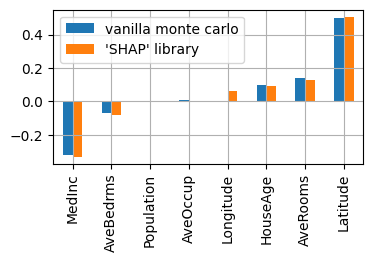

In [152]:
pd.DataFrame(np.transpose([MC, shap_values]),
             index=X.columns,
             columns=["vanilla monte carlo", "'SHAP' library"]).sort_values(by="'SHAP' library").plot.bar(grid=True, figsize=(4,2))